In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Parameters

In [14]:
reduced = True
dataset_to_fit = 'android_data_latest'
if dataset_to_fit == 'html_data':
    device = 'iphone'
data_type = 'wlk'
data_fit_num = 1

dataset_source_type = 'wlk_7'
dataset_source_num = 4

# Load Data

### Original Data

In [15]:
data_source_url = '../data/dataset'
if reduced:
    data_source_url += '_reduced'

data_source = pd.read_csv(data_source_url + '/' + dataset_source_type + '/sub_{}'.format(dataset_source_num) + '.csv')
data_source = data_source.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_source.columns else None
data_source

,gravity.x,gravity.y,gravity.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.121138,0.974452,-0.189103,-0.779741,0.495672,0.594301
1,-0.138265,0.977835,-0.157201,-0.416377,0.541651,0.354757
2,-0.146117,0.978342,-0.146581,-0.162065,0.567739,-0.526576
3,-0.155590,0.978078,-0.138367,-0.059711,-0.361272,0.916244
4,-0.161848,0.980369,-0.112564,0.075652,-0.448585,0.873779
...,...,...,...,...,...,...
6466,0.061636,0.984852,0.161966,0.076166,-0.070347,0.081533
6467,0.058643,0.982137,0.178694,0.105572,-0.046499,0.047472
6468,0.052053,0.979115,0.196437,0.133692,0.118724,-0.085262
6469,0.043079,0.975567,0.215352,0.171902,0.122944,-0.341450


### Data to Fit

In [16]:
data_to_fit_url = '../data/' + dataset_to_fit

if reduced:
    data_to_fit_url += '_reduced'

if dataset_to_fit == 'android_data_latest':
    data_to_fit = pd.read_csv(data_to_fit_url + '/' + data_type + '/{}{}'.format(data_type, data_fit_num) + '-SensorData.csv')
    data_to_fit = data_to_fit.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_to_fit.columns else data_to_fit
    data_to_fit = data_to_fit.drop('id', axis=1) if 'id' in data_to_fit.columns else data_to_fit

if dataset_to_fit == 'html_data':
    data_to_fit = pd.read_csv(data_to_fit_url + '/' + device + '/' + data_type + '/{}_{}'.format(data_type, data_fit_num) + '.csv')
    data_to_fit = data_to_fit.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_to_fit.columns else data_to_fit

data_to_fit

,Gravity X,Gravity Y,Gravity Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,-7.621599,-2.219717,5.757993,-4.823378,-2.148202,-8.000753
1,-7.990885,-2.390984,5.157455,0.396557,-4.395077,-6.016367
2,-8.297370,-2.581800,4.545146,3.260048,-5.152364,-5.159850
3,-8.540878,-2.790551,3.928944,0.280963,-5.523009,-6.095089
4,-8.710469,-3.028502,3.335612,1.393869,-3.125490,-2.825042
...,...,...,...,...,...,...
1056,0.044828,-9.600049,2.001859,0.185090,-0.557045,0.811931
1057,0.034970,-9.597095,2.016176,-0.494582,-0.124255,0.404966
1058,0.013579,-9.592072,2.040189,-0.200251,-0.282507,0.304338
1059,-0.002335,-9.587220,2.062904,-0.179549,-0.186802,0.147548


In [94]:
# Removing Outliers from Data
def remove_outliers(df):
    result = df.copy()
    for feature in df.columns:
        if pd.api.types.is_numeric_dtype(df[feature]):
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            result = result[(result[feature] >= lower_bound) & (result[feature] <= upper_bound)]
    return result

data_to_fit = remove_outliers(data_to_fit)

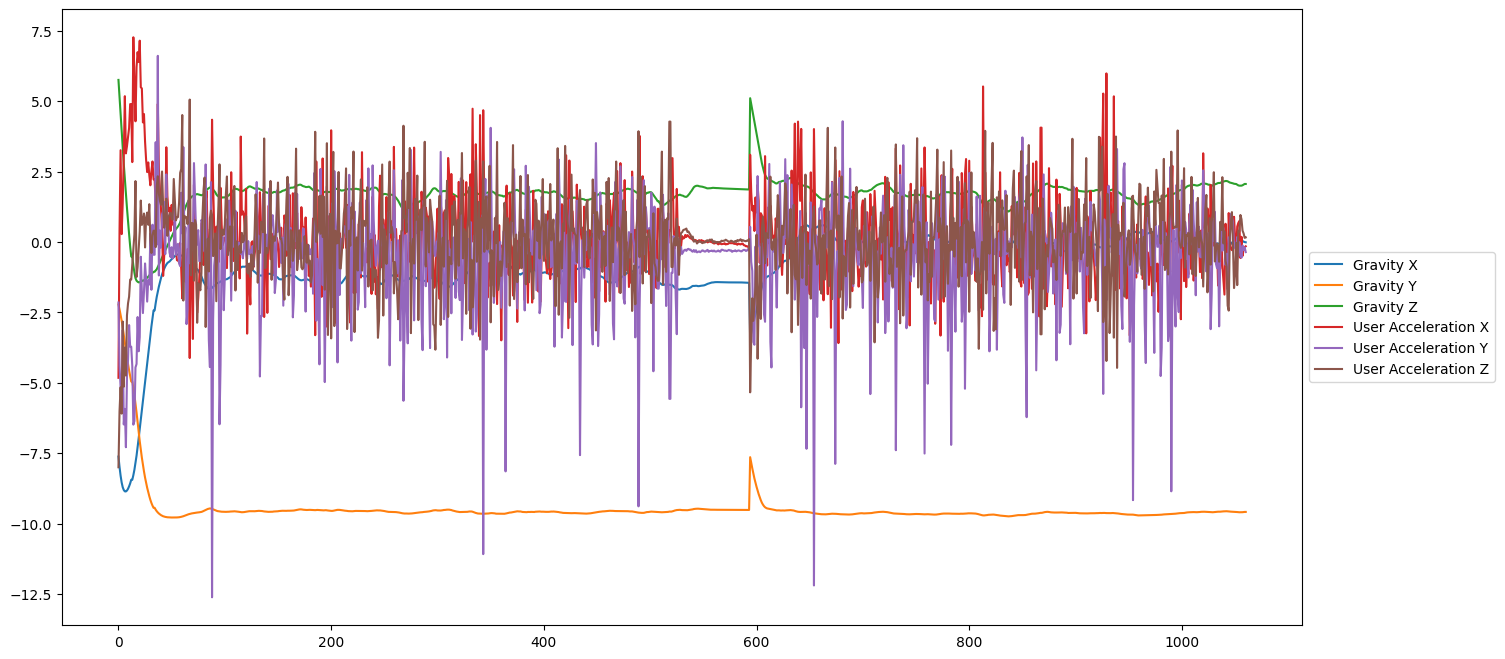

In [17]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(data_to_fit)
plt.legend(data_to_fit.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

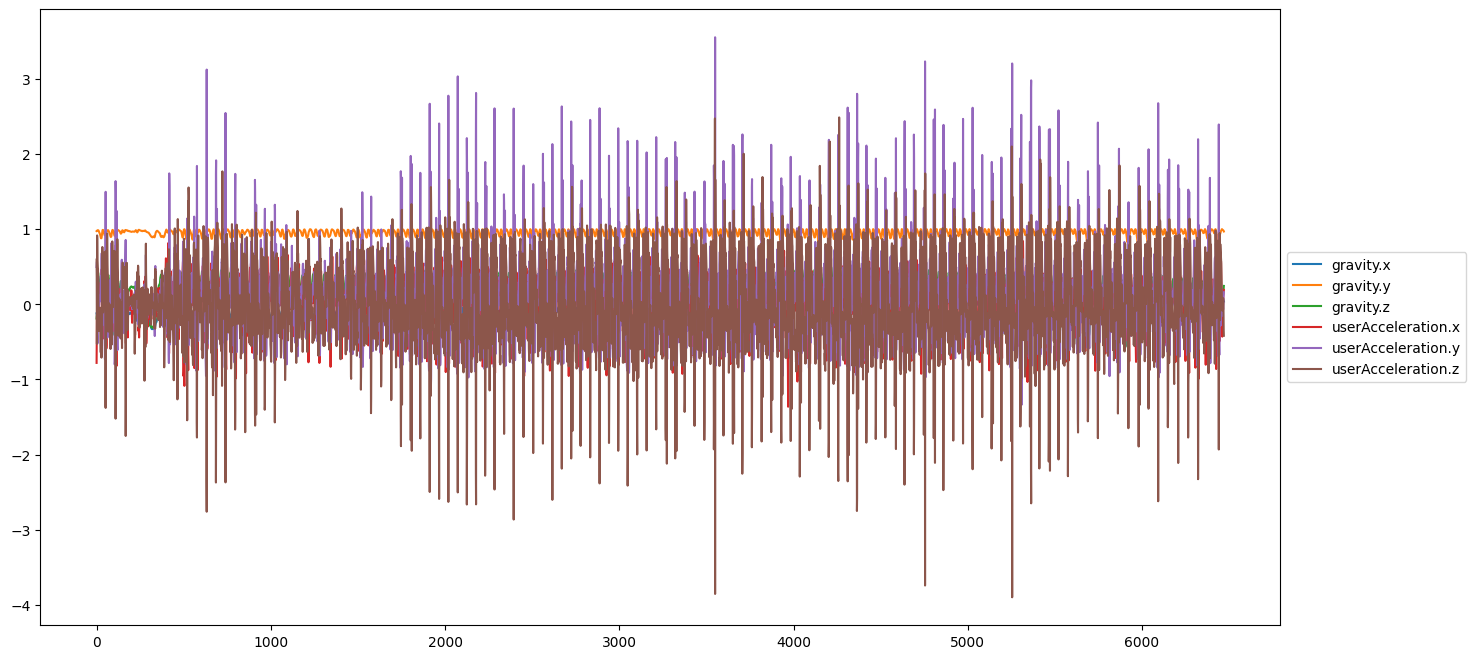

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(data_source)
plt.legend(data_source.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fit the Length

In [19]:
if len(data_source) >= len(data_to_fit):
    data_source = data_source[:len(data_to_fit)]
else:
    data_to_fit = data_to_fit[:len(data_source)]

print('Data source shape: {}'.format(data_source.shape))
print('Data to fit shape: {}'.format(data_to_fit.shape))

Data source shape: (1061, 6)
Data to fit shape: (1061, 6)


# Calculate Factor with Linear Regression

In [20]:
# find scaling factor of each column wuth linear regression (fit android data to original data)
def calculate_scaling_factors(df, df_o):
    scaling_factors = {}

    for i in range(len(df.columns)):
        X = df.iloc[:, i].values.reshape(-1, 1)
        y = df_o.iloc[:, i].values.reshape(-1, 1)

        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        scaling_factors[df.columns[i]] = model.coef_[0][0]

    return scaling_factors

In [21]:
# predict
scaling_factors = calculate_scaling_factors(data_to_fit, data_source)
scaling_factors

{'Gravity X': 0.05391829524771258,
 'Gravity Y': -0.10016194958692945,
 'Gravity Z': 0.0055831649450503755,
 'User Acceleration X': 0.011470845449928734,
 'User Acceleration Y': -0.010506739338576385,
 'User Acceleration Z': -0.00842432607181442}

# Save Scaling Factors

In [23]:
# Write to Constants File
constant_file_url = '../constants.txt'
if reduced:
    constant_file_url = '../constants_reduced.txt'

with open(constant_file_url, 'a') as f:
    f.write(str(scaling_factors) + '\n')

In [24]:
# opening scaling factor file to read the dictionary
factors = []
with open(constant_file_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))

factors

[{'Gravity X': 0.05391829524771258,
  'Gravity Y': -0.10016194958692945,
  'Gravity Z': 0.0055831649450503755,
  'User Acceleration X': 0.011470845449928734,
  'User Acceleration Y': -0.010506739338576385,
  'User Acceleration Z': -0.00842432607181442}]